In [1]:
from matplotlib import pyplot as plt

import pyreadr
import numpy as np
import pandas as pd
import copy
from scipy.optimize import fmin_slsqp
from sklearn.metrics import mean_squared_error

In [2]:
START_TIME = 1970
INTERVENTION_TIME = 1989
STOP_TIME = 2001

'smoking.rda' data taken from https://github.com/johnson-shuffle/mixtape/tree/master/data

'prop99.csv' taken from https://github.com/jehangiramjad/tslib/tree/master/tests/testdata

In [3]:
df_outcome_raw = pd.read_csv('prop99.csv')
df_outcome_raw = df_outcome_raw[df_outcome_raw['SubMeasureDesc'] == 'Cigarette Consumption (Pack Sales Per Capita)']
df_outcome = pd.DataFrame(df_outcome_raw.pivot_table(values='Data_Value', index='LocationDesc', columns=['Year']).to_records())

rda_predictors = pyreadr.read_r('smoking.rda')
df_predictors = pd.DataFrame(list(rda_predictors.values())[0])

In [4]:
print(f'In the original dataset there are {df_outcome.LocationDesc.unique().shape[0]} states')
# Section 3.2 in the paper
bad_states = ['Massachusetts', 'Arizona', 'Oregon', 'Florida', 'Alaska', 'Hawaii', 'Maryland', 
              'Michigan', 'New Jersey', 'New York', 'Washington', 'District of Columbia']

df_outcome.drop(df_outcome[df_outcome['LocationDesc'].isin(bad_states)].index, inplace=True)
ca_id = df_outcome[df_outcome['LocationDesc'] == 'California'].index.item()
df_outcome = df_outcome.reset_index()
df_outcome = df_outcome.rename(columns={'index': 'org_index'})
print(f'After filtering out some states, we are left with {df_outcome.LocationDesc.unique().shape[0]} states (including California):')
df_outcome.head()

In the original dataset there are 51 states
After filtering out some states, we are left with 39 states (including California):


,org_index,LocationDesc,1970,1971,1972,1973,1974,1975,1976,1977,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,0,Alabama,89.8,95.4,101.1,102.9,108.2,111.7,116.2,117.1,...,82.4,83.3,80.2,78.0,75.6,71.5,68.4,67.2,64.6,61.7
1,3,Arkansas,100.3,104.1,103.9,108.0,109.7,114.8,119.1,122.6,...,82.1,81.4,78.4,77.0,72.6,63.2,61.1,60.5,57.5,54.4
2,4,California,123.0,121.0,123.5,124.4,126.7,127.1,128.0,126.4,...,33.1,32.9,31.8,30.3,28.8,26.3,26.0,25.2,23.9,22.7
3,5,Colorado,124.8,125.5,134.3,137.9,132.8,131.0,134.2,132.0,...,57.9,53.1,51.1,48.4,46.0,41.4,40.6,40.6,38.3,36.7
4,6,Connecticut,120.0,117.6,110.8,109.3,112.4,110.2,113.4,117.3,...,49.9,50.9,50.5,47.4,45.9,40.8,36.3,33.5,31.4,30.1


In [5]:
df_outcome_ca = df_outcome.loc[df_outcome['LocationDesc'] == 'California', :]
df_outcome_control = df_outcome.loc[df_outcome['LocationDesc'] != 'California', :]

ca_outcomes_pre = df_outcome_ca.loc[:,[str(i) for i in list(range(START_TIME, INTERVENTION_TIME))]].values.reshape(-1,1)
control_outcomes_pre = df_outcome_control.loc[:,[str(i) for i in list(range(START_TIME, INTERVENTION_TIME))]].values.transpose()

ca_outcomes_post = df_outcome_ca.loc[:,[str(i) for i in list(range(INTERVENTION_TIME, STOP_TIME))]].values.reshape(-1,1)
control_outcomes_post = df_outcome_control.loc[:,[str(i) for i in list(range(INTERVENTION_TIME, STOP_TIME))]].values.transpose()

Z0 = control_outcomes_pre
Z1 = ca_outcomes_pre
Y0 = control_outcomes_post
Y1 = ca_outcomes_post

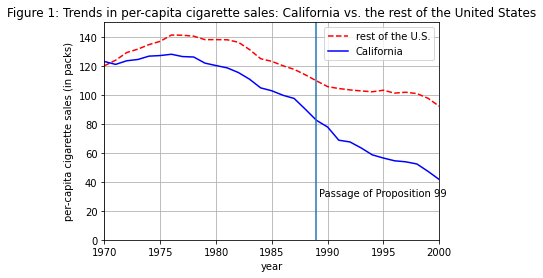

In [6]:
mean_outcomes = np.vstack([Z0, Y0]).mean(axis=1)
CA_outcomes = np.vstack([Z1, Y1]).flatten()
plt.plot(range(START_TIME,STOP_TIME),mean_outcomes, 'r--', label="rest of the U.S.");
plt.plot(range(START_TIME,STOP_TIME),CA_outcomes, 'b-', label="California");

plt.ylabel('per-capita cigarette sales (in packs)')
plt.xlabel('year')
plt.legend(loc='upper right')
plt.title("Figure 1: Trends in per-capita cigarette sales: California vs. the rest of the United States")
plt.axvline(INTERVENTION_TIME)
plt.text(x=INTERVENTION_TIME+0.2, y=30, s='Passage of Proposition 99')
plt.xlim([START_TIME, STOP_TIME-1])
plt.ylim([0, 150])
plt.grid()
plt.show()

In [7]:
def extract_predictor_vec(state):
    df_outcome_state = df_outcome[df_outcome['LocationDesc'] == state]
    cigsale88_predictor = df_outcome_state['1988'].item()
    cigsale80_predictor = df_outcome_state['1980'].item()
    cigsale75_predictor = df_outcome_state['1975'].item()
    
    state_id_predictors_df = df_outcome[df_outcome['LocationDesc'] == 'California'].index.item() + 1
    df_predictors_state = df_predictors[df_predictors['state'] == state_id_predictors_df]
    beer_predictor = df_predictors_state.loc[(df_predictors_state['year'] >= 1984) & (df_predictors_state['year'] < INTERVENTION_TIME), 'beer'].mean()
    age15to24_predictor = df_predictors_state.loc[(df_predictors_state['year'] >= 1980) & (df_predictors_state['year'] < INTERVENTION_TIME), 'age15to24'].mean()*100  # Should I turn multiply by 100? In table 1 it looks like it
    retprice_predictor = df_predictors_state.loc[(df_predictors_state['year'] >= 1980) & (df_predictors_state['year'] < INTERVENTION_TIME), 'retprice'].mean()
    lnincome_predictor = df_predictors_state.loc[(df_predictors_state['year'] >= 1980) & (df_predictors_state['year'] < INTERVENTION_TIME), 'lnincome'].mean()
    
    return np.array([lnincome_predictor, age15to24_predictor, retprice_predictor, beer_predictor,  
                     cigsale88_predictor, cigsale80_predictor, cigsale75_predictor]).reshape(-1,1)

In [8]:
control_predictors = []
for state in df_outcome['LocationDesc'].unique():
    state_predictor_vec = extract_predictor_vec(state)
    if state == 'California':
        ca_predictors = state_predictor_vec
    else:
        control_predictors += [state_predictor_vec]

control_predictors = np.hstack(control_predictors)

X0 = control_predictors
X1 = ca_predictors

array([[ 10.07655864],
       [ 17.35323817],
       [ 89.42222341],
       [ 24.28000031],
       [ 90.1       ],
       [120.2       ],
       [127.1       ]])

In [14]:
def w_mse(w, v, x0, x1): return mean_squared_error(x1, x0.dot(w), sample_weight=v)

def w_constraint(w, v, x0, x1): return np.sum(w) - 1

def v_constraint(V, W, X0, X1, Z0, Z1): return np.sum(V) - 1

def fun_w(w, v, x0, x1): return fmin_slsqp(w_mse, w, bounds=[(0.0, 1.0)]*len(w), f_eqcons=w_constraint, 
                                           args=(v, x0, x1), disp=False, full_output=True)[0]

def fun_v(v, w, x0, x1, z0, z1): return mean_squared_error(z1, z0.dot(fun_w(w, v, x0, x1)))

def solve_synthetic_control(X0, X1, Z0, Z1, Y0):
    k,j = X0.shape
    V0 = 1/k*np.ones(k)
    W0 = 1/j*np.zeros(j).transpose()
    V = fmin_slsqp(fun_v, V0, args=(W0, X0, X1, Z0, Z1), bounds=[(0.0, 1.0)]*len(V0), disp=True, f_eqcons=v_constraint, acc=1e-6)
    W = fun_w(W0, V, X0, X1)
    return V, W

V, W = solve_synthetic_control(X0, X1, Z0, Z1, Y0)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 23.458592721256306
            Iterations: 5
            Function evaluations: 9
            Gradient evaluations: 1


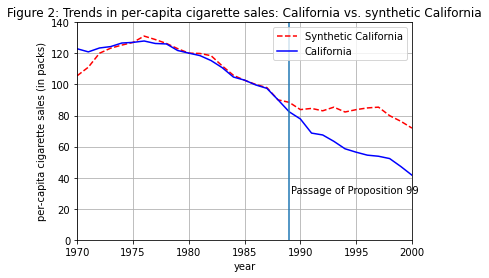

In [15]:
SC_outcomes = np.vstack([Z0, Y0]).dot(W)
CA_outcomes = np.vstack([Z1, Y1]).flatten()
plt.plot(range(START_TIME,STOP_TIME),SC_outcomes, 'r--', label="Synthetic California");
plt.plot(range(START_TIME,STOP_TIME),CA_outcomes, 'b-', label="California");

plt.ylabel('per-capita cigarette sales (in packs)')
plt.xlabel('year')
plt.legend(loc='upper right')
plt.title("Figure 2: Trends in per-capita cigarette sales: California vs. synthetic California")
plt.axvline(INTERVENTION_TIME)
plt.text(x=INTERVENTION_TIME+0.2, y=30, s='Passage of Proposition 99')
plt.xlim([START_TIME, STOP_TIME-1])
plt.ylim([0, 140])
plt.grid()
plt.show()
    

#### Table 1

In [11]:
mean_predictors = X0.mean(axis=1)
print("Table 1: Cigarette sales predictor means \n")
print(pd.DataFrame(np.hstack([X1, X0.dot(W).reshape(-1,1), mean_predictors.reshape(-1,1)]), 
             columns=['Real California', 'Synthetic California', 'Average of 38 Controls']))

Table 1: Cigarette sales predictor means 

   Real California  Synthetic California  Average of 38 Controls
0        10.076559             10.076559               10.076559
1        17.353238             17.353238               17.353238
2        89.422223             89.422223               89.422223
3        24.280000             24.280000               24.280000
4        90.100000             90.099950              113.823684
5       120.200000            120.200020              138.089474
6       127.100000            127.100214              136.931579


#### Table 2: Top 5 donors

In [16]:
list(df_outcome['LocationDesc'].values[1+np.flip(W.argsort())][:5])
# In the paper: Colorado, Connecticut, Montana, Nevada, Utah

['Utah', 'North Carolina', 'North Dakota', 'Montana', 'New Hampshire']

#### Figure 3

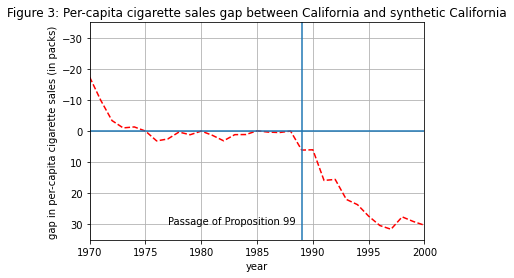

In [13]:
Gap_outcome = np.vstack([Z0, Y0]).dot(W) - np.vstack([Z1, Y1]).flatten()
plt.plot(range(START_TIME,STOP_TIME),Gap_outcome, 'r--');

plt.ylabel('gap in per-capita cigarette sales (in packs)')
plt.xlabel('year')
plt.title("Figure 3: Per-capita cigarette sales gap between California and synthetic California")
plt.axhline(0)
plt.axvline(INTERVENTION_TIME)
plt.text(x=INTERVENTION_TIME-12, y=30, s='Passage of Proposition 99')
plt.xlim([START_TIME, STOP_TIME-1])
plt.ylim([35, -35])
plt.grid()
plt.show()